In [3]:
### PACKAGES
import csv
import numpy as np
import cv2
import os
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import pickle
from copy import deepcopy
from asift import *
#import keras
from tensorflow import keras #for kelvin's machine
from find_obj import init_feature, filter_matches, explore_match
from scipy import ndimage 


In [4]:
### CONSTANTS
ROOTPATH = './'
IMG_HEIGHT = 490
IMG_WIDTH = 680
NUM_CHANNELS = 3

In [6]:
train_img_names = [] # list of train image names as strings
train_img_labels = [] # list of train images labels as tuples (latitude, longitude)
with open('COMP90086_2021_Project_train/train.csv') as train_csv:
    reader = csv.reader(train_csv, delimiter=',')
    next(reader) # skip header row
    for row in reader:
        name = row[0] # string
        label = (float(row[1]), float(row[2])) # tuple
        train_img_names.append(name)
        train_img_labels.append(label)
'''
# train images stored as numpy array
resize = 0.5
IMG_HEIGHT = int(IMG_HEIGHT * resize)
IMG_WIDTH = int(IMG_WIDTH * resize)
train_size = (len(train_img_names), IMG_HEIGHT, IMG_WIDTH,NUM_CHANNELS )
#print(train_images.shape)


train_images = np.zeros(train_size, dtype='uint8')
for i in range(len(train_img_names)):
    name = train_img_names[i]
    subpath = 'COMP90086_2021_Project_train/train/' + name + '.jpg'
    img = cv2.imread(os.path.join(ROOTPATH, subpath))
    img = cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
#     print(img.shape)
    train_images[i] = img

# train labels stored as numpy array
train_labels = np.array(train_img_labels)
print(train_labels[0])
print(train_images.shape)
'''

"\n# train images stored as numpy array\nresize = 0.5\nIMG_HEIGHT = int(IMG_HEIGHT * resize)\nIMG_WIDTH = int(IMG_WIDTH * resize)\ntrain_size = (len(train_img_names), IMG_HEIGHT, IMG_WIDTH,NUM_CHANNELS )\n#print(train_images.shape)\n\n\ntrain_images = np.zeros(train_size, dtype='uint8')\nfor i in range(len(train_img_names)):\n    name = train_img_names[i]\n    subpath = 'COMP90086_2021_Project_train/train/' + name + '.jpg'\n    img = cv2.imread(os.path.join(ROOTPATH, subpath))\n    img = cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))\n#     print(img.shape)\n    train_images[i] = img\n\n# train labels stored as numpy array\ntrain_labels = np.array(train_img_labels)\nprint(train_labels[0])\nprint(train_images.shape)\n"

In [7]:
test_img_names = [] # list of test image names as strings
with open('COMP90086_2021_Project_test/imagenames.csv') as test_csv:
    reader = csv.reader(test_csv, delimiter=',')
    next(reader) # skip header row
    for row in reader:
        name = row[0] # string
        test_img_names.append(name)
'''
# test images stored as numpy array
test_size = (len(test_img_names), IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)
test_images = np.zeros(test_size, dtype='uint8')
for i in range(len(test_img_names)):
    name = test_img_names[i]
    subpath = 'COMP90086_2021_Project_test/test/' + name + '.jpg'
    img = cv2.imread(os.path.join(ROOTPATH, subpath))
    img = cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))

    
    test_images[i] = img
    
# train_images = train_images.reshape(train_images.shape[0], 32, 32, 3).astype('float32')
# test_images = test_images.reshape(test_images.shape[0], 32, 32, 3).astype('float32')
'''

"\n# test images stored as numpy array\ntest_size = (len(test_img_names), IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)\ntest_images = np.zeros(test_size, dtype='uint8')\nfor i in range(len(test_img_names)):\n    name = test_img_names[i]\n    subpath = 'COMP90086_2021_Project_test/test/' + name + '.jpg'\n    img = cv2.imread(os.path.join(ROOTPATH, subpath))\n    img = cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))\n\n    \n    test_images[i] = img\n    \n# train_images = train_images.reshape(train_images.shape[0], 32, 32, 3).astype('float32')\n# test_images = test_images.reshape(test_images.shape[0], 32, 32, 3).astype('float32')\n"

In [ ]:
##CHECK
train_img_1 = cv2.cvtColor(train_images[0], cv2.COLOR_BGR2RGB)
train_img_n = cv2.cvtColor(train_images[-1], cv2.COLOR_BGR2RGB)
test_img_1 = cv2.cvtColor(test_images[0], cv2.COLOR_BGR2RGB)
print(train_img_1.shape)
test_img_n = cv2.cvtColor(test_images[-1], cv2.COLOR_BGR2RGB)

plt.subplot(2,2,1)
plt.imshow(train_img_1) 
plt.title('train image 1')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(train_img_n) 
plt.title('train image n')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(test_img_1) 
plt.title('test image 1')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(test_img_n) 
plt.title('test image n')
plt.axis('off')
plt.show()

In [ ]:
# FIRST ATTEMPT: BASELINE 
model = keras.models.Sequential()

model.add(layers.Input((IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(2))


#op = keras.optimizers.adam_v2.Adam()
op = keras.optimizers.Adam() # for kelvin's machine
model.compile(loss='mae', optimizer=op)
print(train_images.shape)
model.summary()

h = model.fit(train_images, train_labels,verbose = 1,batch_size=1,validation_split = 0.1,epochs = 20)

In [ ]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

### SIFT + FLANN

In [ ]:
### SIFT + FLANN

k_nn = 2
lowe_ratio = 0.7
num_closest_matches = 5

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

# If there exists a checkpoint, use saved weights and indices
if os.path.exists('./checkpoint/weights.pickle') and os.path.exists('./checkpoint/indices.pickle'):
    with open(os.path.join("checkpoint","weights.pickle"),'rb') as handle:
        weights = pickle.load(handle)
    with open(os.path.join(os.getcwd(),"checkpoint","indices.pickle"),'rb') as handle:
        indices = pickle.load(handle)
        
    # Skip already completed test images
    test_images_sift = test_images[len(weights):]
    print("Found checkpoint, skipping to test image",len(weights))
else:
    test_images_sift = deepcopy(test_images)
    weights = []
    indices = []
    

sift = cv2.SIFT_create() # initialise SIFT detector

for i in range(len(test_images_sift)):    
    print(i)

    test_image = test_images_sift[i]
    # convert test image to grayscale
    gray_test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
    
    # SIFT keypoints and descriptors for test image
    keypoints_test, descriptors_test = sift.detectAndCompute(gray_test_image, None)
        
    # initialise FLANN
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    
    # stores 5 highest number of keypoint matches
    best_num_matches = np.zeros(num_closest_matches, dtype='uint64')
    
    matches_index = np.zeros(num_closest_matches,dtype='uint64')
    # stores 5 train images with highest number of keypoint matches
    #best_image_matches = np.zeros((num_closest_matches, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS), dtype='uint8')
    # stores  corresponding matching images 
    #circles_and_lines = np.zeros((num_closest_matches, IMG_HEIGHT, IMG_WIDTH*2, NUM_CHANNELS), dtype='uint8')

    for j in range(len(train_images)):
        train_image = train_images[j]
        # convert train image to grayscale
        gray_train_image = cv2.cvtColor(train_image,cv2.COLOR_BGR2GRAY)
        
        # SIFT keypoints and descriptors for train image
        keypoints_train, descriptors_train = sift.detectAndCompute(gray_train_image, None)
        
        
        
        # when there is no descriptor less than k_nn descriptors
        if descriptors_test is None or descriptors_train is None or \
        descriptors_test.shape[0] < k_nn or descriptors_train.shape[0] < k_nn:
            continue
            
        # Draws a circle with the size of each keypoint and show its orientation
        keypoints_test_with_size = cv2.drawKeypoints(gray_test_image, keypoints_test, None,
                                                     flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        keypoints_train_with_size = cv2.drawKeypoints(gray_train_image, keypoints_train, None,
                                                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        
        # Matching descriptors using KNN algorithm
        matches = flann.knnMatch(descriptors_test, descriptors_train, k=k_nn)
        
        # Create a mask to draw all good matches
        matchesMask = []
        # Store all good matches as per Lowe's Ratio test.
        good = []
        for m,n in matches:
            if m.distance < lowe_ratio *n.distance:
                good.append(m)
                matchesMask.append([1,0]) # Match
            else:
                matchesMask.append([0,0]) # Mismatch
        num_matches = len(good)
        
        # Draw all good matches
        draw_params = dict(#matchColor = (0,255,0),  #If you want a specific colour
                           #singlePointColor = (255,0,0), #If you want a specific colour
                            matchesMask = matchesMask,
                            flags = cv2.DrawMatchesFlags_DEFAULT)

        good_matches = cv2.drawMatchesKnn(gray_test_image, keypoints_test, gray_train_image,
                                          keypoints_train, matches, None, **draw_params)
        
        # compares to closest matches and update as necessary
        for k in range(num_closest_matches):
            if num_matches >= best_num_matches[k]:
                best_num_matches = np.insert(best_num_matches, k, num_matches, 0)
                best_num_matches = np.delete(best_num_matches, -1, 0)
                matches_index = np.insert(matches_index, k, j, 0)
                matches_index = np.delete(matches_index, -1, 0)
                #best_image_matches = np.insert(best_image_matches, k, train_image, 0)
                #best_image_matches = np.delete(best_image_matches, -1, 0)
                #circles_and_lines = np.insert(circles_and_lines, k, good_matches, 0)
                #circles_and_lines = np.delete(circles_and_lines, -1, 0)
                break
    
    '''
    # display 5 closest images
    for z in range(num_closest_matches):
        plt.subplots(figsize=(10, 10)) 
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB), cmap='gray')  
        plt.title('Test Image')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(best_image_matches[z], cv2.COLOR_BGR2RGB), cmap='gray')  
        plt.title('Train Image')
        plt.axis('off')
        plt.show()
        
        plt.figure(figsize=(15, 15))
        plt.imshow(circles_and_lines[z])
        plt.title(f'Number of good matches between two images: {best_num_matches[z]}')
        plt.axis('off')
        plt.show()
    '''
    weights.append(list(best_num_matches))
    indices.append(list(matches_index))
    
    if i % 5 == 0: # Save weights and Indices every 5 test images 
        with open(os.path.join("checkpoint","weights.pickle"),'wb') as handle:
            pickle.dump(weights, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
        with open(os.path.join(os.getcwd(),"checkpoint","indices.pickle"),'wb') as handle:
            pickle.dump(indices, handle, protocol=pickle.HIGHEST_PROTOCOL)
            

In [ ]:
### SIFT + FLANN

predictions_top1 = []
predictions_avg = []
predictions_weighted_avg = []
for i in range(len(indices)):
    weight = weights[i]
    test_img_indices = indices[i]
    
    ### PREDICTIONS_TOP_1
    predictions_top1.append(train_img_labels[test_img_indices[0]])
    
    ### PREDICTIONS_AVG
    pred_avg_x = 0
    pred_avg_y = 0
    for ind in test_img_indices:
        x_lab, y_lab= train_img_labels[ind]
        pred_avg_x += x_lab
        pred_avg_y += y_lab
    pred_avg_x /= len(test_img_indices)
    pred_avg_y /= len(test_img_indices)
    
    predictions_avg.append((pred_avg_x, pred_avg_y))
    
    ### PREDICTIONS_WEIGHTED_AVG
    pred_weighted_avg_x = 0
    pred_weighted_avg_y =0
    for j in range(len(test_img_indices)):
        x_lab, y_lab= train_img_labels[test_img_indices[j]]
        w = weight[j] / sum(weight)
        pred_weighted_avg_x += x_lab * w
        pred_weighted_avg_y += y_lab * w
    
    predictions_weighted_avg.append((pred_weighted_avg_x, pred_weighted_avg_y))

In [ ]:
### SIFT + FLANN

header = ['id', 'x', 'y']
with open(ROOTPATH + 'predictions_top1.csv', 'w', newline='') as top1:
    writer = csv.writer(top1)
    writer.writerow(header)
    for i in range(len(test_img_names)):
        img_name = test_img_names[i]
        x_val, y_val = predictions_top1[i]
        data = [img_name, str(x_val), str(y_val)]
        writer.writerow(data)
    top1.close()
    
with open(ROOTPATH + 'predictions_avg.csv', 'w', newline='') as avg:
    writer = csv.writer(avg)
    writer.writerow(header)
    for i in range(len(test_img_names)):
        img_name = test_img_names[i]
        x_val, y_val = predictions_avg[i]
        data = [img_name, str(x_val), str(y_val)]
        writer.writerow(data)
    avg.close()
    
with open(ROOTPATH + 'predictions_weighted_avg.csv', 'w', newline='') as weighted_avg:
    writer = csv.writer(weighted_avg)
    writer.writerow(header)
    for i in range(len(test_img_names)):
        img_name = test_img_names[i]
        x_val, y_val = predictions_weighted_avg[i]
        data = [img_name, str(x_val), str(y_val)]
        writer.writerow(data)
    weighted_avg.close()

### SIFT FEATURE EXTRACTION, THEN CNN

In [ ]:
train_images_descriptors = np.zeros((len(train_images),200,128))
print(train_images_descriptors.shape)
rows_to_delete = []
descriptors_labels = deepcopy(train_labels)
for i in range(len(train_images)):    

    image = train_images[i]
    
    # convert test image to grayscale
    gray_train_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    sift = cv2.SIFT_create(200) # initialise SIFT detector
    
    # SIFT keypoints and descriptors for test image
    keypoints_train, descriptors_train = sift.detectAndCompute(gray_train_image, None)
    if descriptors_train is None:
        rows_to_delete.append(i)
        continue
    if descriptors_train.shape[0] < 200:
        times_to_pad =200-descriptors_train.shape[0]
        pad = np.zeros((times_to_pad,128))
        descriptors_train = np.r_[descriptors_train, pad]
    elif descriptors_train.shape[0] > 200:
        descriptors_train = descriptors_train[:200]
    train_images_descriptors[i] = descriptors_train
#     print(descriptors_train.shape)

print(descriptors_labels.shape)
 
if len(rows_to_delete) != 0:
    rows_to_delete.reverse()
    for ind in rows_to_delete:
        train_images_descriptors = np.delete(train_images_descriptors,ind,0)

        descriptors_labels =  np.delete(descriptors_labels,ind,0)
        
        
print(train_images_descriptors.shape)
print(descriptors_labels.shape)


In [ ]:
# Attempt: CNN Using SIFT Descriptors as Features
train_images_descriptors_1 = np.expand_dims(train_images_descriptors, axis=-1)
train_images_descriptors_1 = train_images_descriptors_1/255 # normalise

model = keras.models.Sequential()
model.add(layers.Input((200,128,1)))

# model.add(layers.Conv2D(16, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2,2)))
# model.add(layers.Conv2D(8, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2,2)))
#model.add(layers.Flatten())
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(2))#, activation='softmax'))

op = keras.optimizers.Adam() # for kelvin's machine
model.compile(loss='mae', optimizer=op)
h = model.fit(train_images_descriptors_1, descriptors_labels,verbose = 1,batch_size=50,validation_split = 0.1,epochs = 10)


### ASIFT + FLANN

In [ ]:
### TESTING ASIFT

train_images1 = cv2.cvtColor(train_images[31], cv2.COLOR_BGR2GRAY)

detector, matcher = init_feature("sift-flann")

pool=ThreadPool(processes = cv.getNumberOfCPUs())

for j in range(len(train_images)):
    train_image = train_images[j]
    train_images2 = cv2.cvtColor(train_image, cv.COLOR_BGR2GRAY)

    kp1, desc1 = affine_detect(detector, train_images1, pool=pool)
    kp2, desc2 = affine_detect(detector, train_images2, pool=pool)

    if len(desc1) < 2 or len(desc2) < 2:
        continue
    raw_matches = matcher.knnMatch(desc1, trainDescriptors = desc2, k = 2) #2

    p1, p2, kp_pairs = filter_matches(kp1, kp2, raw_matches)
    H, status = cv2.findHomography(p1, p2, cv2.RANSAC, 5.0)
    print('%d / %d  inliers/matched' % (np.sum(status), len(status)))




In [ ]:
### ASIFT + FLANN

k_nn = 2
lowe_ratio = 0.7
num_closest_matches = 5

# Initialize asift with flann (Note: remove -flann to use bruteforce)
detector, matcher = init_feature("sift-flann")
pool=ThreadPool(processes = cv.getNumberOfCPUs())

# If there exists a checkpoint, use saved weights and indices
'''
if os.path.exists('./checkpoint/asift_weights.pickle') and os.path.exists('./checkpoint/asift_indices.pickle'):
    with open(os.path.join("checkpoint","asift_weights.pickle"),'rb') as handle:
        weights = pickle.load(handle)
    with open(os.path.join(os.getcwd(),"checkpoint","asift_indices.pickle"),'rb') as handle:
        indices = pickle.load(handle)
        
    # Skip already completed test images
    test_images_asift=test_images[len(weights):]
    print("Found checkpoint, skipping to test image",len(weights))
else:
    test_images_asift=deepcopy(test_images)
    weights = []
    indices = []
'''
test_images_asift=deepcopy(test_images)
weights=[]
indices=[]
for i in range(1):#range(len(test_images_asift)):    
    #print(i)
    test_image = test_images_asift[i]
    # convert test image to grayscale
    gray_test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
    kp1, desc1 = affine_detect(detector, gray_test_image, pool=pool)

    
    # stores 5 highest number of keypoint matches
    best_matches = np.zeros(num_closest_matches, dtype='uint64')
    
    matches_index = np.zeros(num_closest_matches,dtype='uint64')
    # stores 5 train images with highest number of keypoint matches
    best_image_matches = np.zeros((num_closest_matches, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS), dtype='uint8')
    # stores  corresponding matching images 
    #circles_and_lines = np.zeros((num_closest_matches, IMG_HEIGHT, IMG_WIDTH*2, NUM_CHANNELS), dtype='uint8')

    for j in range(len(train_images)):
        print(j)
        train_image = train_images[j]
        # convert train image to grayscale
        gray_train_image = cv2.cvtColor(train_image,cv2.COLOR_BGR2GRAY)
        
        kp2, desc2 = affine_detect(detector, gray_train_image, pool=pool)
        
        if len(desc1) < k_nn or len(desc2) < k_nn:
            continue
        #matches = flann.knnMatch(descriptors_test, descriptors_train, k=k_nn)
        raw_matches = matcher.knnMatch(desc1, trainDescriptors = desc2, k = k_nn) #2
        
        p1, p2, kp_pairs = filter_matches(kp1, kp2, raw_matches)
        
        if p1.shape[0] < 4 or p2.shape[0] < 4:
            continue
            
        H, status = cv2.findHomography(p1, p2, cv2.RANSAC, 5.0)
        # Where H is the resulting single-strain matrix.
        # status returns a list of feature points that represent successful matches.
        # ptsA, ptsB are keypoints.
        # The three parameters cv2.RANSAC, ransacReprojThreshold, maxIters are related to RANSAC.
        # ransacReprojThreshold: Maximum reprojection error in the RANSAC algorithm to consider a point as an inlier. 
        # maxIters: The maximum number of RANSAC-based robust method iterations.
        #print('%d / %d  inliers/matched' % (np.sum(status), len(status)))
        
        num_good_matches = np.sum(status)
        
        # compares to closest matches and update as necessary
        for k in range(num_closest_matches):
            if num_good_matches >= best_matches[k]:
                best_matches = np.insert(best_matches, k, num_good_matches, 0)
                best_matches = np.delete(best_matches, -1, 0)
                matches_index = np.insert(matches_index, k, j, 0)
                matches_index = np.delete(matches_index, -1, 0)
                best_image_matches = np.insert(best_image_matches, k, train_image, 0)
                best_image_matches = np.delete(best_image_matches, -1, 0)
                #circles_and_lines = np.insert(circles_and_lines, k, good_matches, 0)
                #circles_and_lines = np.delete(circles_and_lines, -1, 0)
                break
    
    
    # display 5 closest images
    for z in range(num_closest_matches):
        plt.subplots(figsize=(10, 10)) 
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB), cmap='gray')  
        plt.title('Test Image')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(best_image_matches[z], cv2.COLOR_BGR2RGB), cmap='gray')  
        plt.title('Train Image')
        plt.axis('off')
        plt.show()
        print("NUMBER OF GOOD MATCHES: ", best_matches[z])
        
        #plt.figure(figsize=(15, 15))
        #plt.imshow(circles_and_lines[z])
        #plt.title(f'Number of good matches between two images: {best_num_matches[z]}')
        #plt.axis('off')
        #plt.show()
    
    weights.append(list(best_matches))
    indices.append(list(matches_index))
    
    if i % 5 == 0: # Save weights and Indices every 5 test images 
        with open(os.path.join("checkpoint","asift_weights.pickle"),'wb') as handle:
            pickle.dump(weights, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
        with open(os.path.join(os.getcwd(),"checkpoint","asift_indices.pickle"),'wb') as handle:
            pickle.dump(indices, handle, protocol=pickle.HIGHEST_PROTOCOL)
            

### SELF-SUPERVISED LEARNING

In [8]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# train images stored as numpy array
train_size = (len(train_img_names), 128, 128 ,NUM_CHANNELS )
train_images_ss = np.zeros(train_size, dtype='uint8')
for i in range(len(train_img_names)):
    name = train_img_names[i]
    subpath = 'COMP90086_2021_Project_train/train/' + name + '.jpg'
    img = cv2.imread(os.path.join(ROOTPATH, subpath))
    img = cv2.resize(img,(128,128))
    train_images_ss[i] = img
train_images_ss = train_images_ss.astype(float)/255
# train labels stored as numpy array
train_labels_ss = np.array(train_img_labels)


# test images stored as numpy array
test_size = (len(test_img_names), 128, 128, NUM_CHANNELS)
test_images_ss = np.zeros(test_size, dtype='uint8')
for i in range(len(test_img_names)):
    name = test_img_names[i]
    subpath = 'COMP90086_2021_Project_test/test/' + name + '.jpg'
    img = cv2.imread(os.path.join(ROOTPATH, subpath))
    img = cv2.resize(img,(128,128))
    test_images_ss[i] = img
test_images_ss = test_images_ss.astype(float)/255

print(train_images_ss.shape)
print(train_labels_ss.shape)
print(test_images_ss.shape)


(7500, 128, 128, 3)
(7500, 2)
(1200, 128, 128, 3)


In [9]:
# shuffle training instances
idx = np.random.randint(train_images_ss.shape[0], size=train_images_ss.shape[0])
train_images_ss_shuffled = train_images_ss[idx,:,:,:]
train_labels_ss_shuffled = train_labels_ss[idx,:]
print(train_images_ss_shuffled.shape)
print(train_labels_ss_shuffled.shape)

(7500, 128, 128, 3)
(7500, 2)


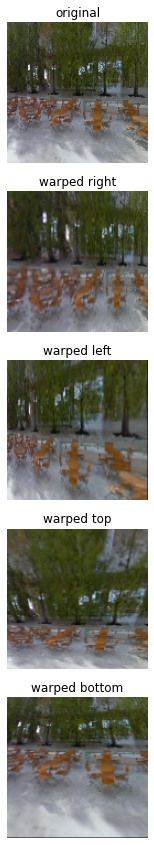

In [128]:
from skimage import transform
from skimage.transform import warp
from skimage.transform import ProjectiveTransform

img = deepcopy(train_images_ss[2])

original = np.array([[0,0],[0,128],[128,0],[128,128]])
warp_right = np.array([[0,32],[0,96],[128,0],[128,128]])
warp_left = np.array([[0,0],[0,128],[128,32],[128,96]])
warp_top = np.array([[32,0],[0,128],[96,0],[128,128]])
warp_bottom = np.array([[0,0],[32,128],[128,0],[96,128]])
transform_right = ProjectiveTransform()
transform_right.estimate(original, warp_right)
transform_left = ProjectiveTransform()
transform_left.estimate(original, warp_left)
transform_top = ProjectiveTransform()
transform_top.estimate(original, warp_top)
transform_bottom = ProjectiveTransform()
transform_bottom.estimate(original, warp_bottom)

warped_img_right = warp(img, transform_right)
warped_img_left = warp(img, transform_left)
warped_img_top = warp(img, transform_top)
warped_img_bottom = warp(img, transform_bottom)


plt.subplots(figsize=(15, 15)) 
plt.subplot(5,1,1)
plt.imshow(img)
plt.title('original')
plt.axis('off')
plt.subplot(5,1,2)
plt.imshow(warped_img_right)
plt.title('warped right')
plt.axis('off')
plt.subplot(5,1,3)
plt.imshow(warped_img_left)
plt.title('warped left')
plt.axis('off')
plt.subplot(5,1,4)
plt.imshow(warped_img_top)
plt.title('warped top')
plt.axis('off')
plt.subplot(5,1,5)
plt.imshow(warped_img_bottom)
plt.title('warped bottom')
plt.axis('off')
plt.show()

In [29]:
from skimage import transform
from skimage.transform import warp, ProjectiveTransform
# from scipy import ndimage 

original = np.array([[0,0],[0,128],[128,0],[128,128]])
warp_right = np.array([[0,32],[0,96],[128,0],[128,128]])
warp_left = np.array([[0,0],[0,128],[128,32],[128,96]])
warp_top = np.array([[32,0],[0,128],[96,0],[128,128]])
warp_bottom = np.array([[0,0],[32,128],[128,0],[96,128]])
transform_right = ProjectiveTransform()
transform_right.estimate(original, warp_right)
transform_left = ProjectiveTransform()
transform_left.estimate(original, warp_left)
transform_top = ProjectiveTransform()
transform_top.estimate(original, warp_top)
transform_bottom = ProjectiveTransform()
transform_bottom.estimate(original, warp_bottom)

train_images_warp=np.zeros_like(train_images_ss_shuffled)  
train_label_warp=np.zeros((train_labels_ss_shuffled.shape[0],1) ) 
#train_images_rot=np.zeros_like(train_images_ss_shuffled)  
#train_label_rot=np.zeros((train_labels_ss_shuffled.shape[0],1) )
#0: no warping, 1 warp right, 2 warp left, 3 warp top, 4 warp bottom
for i in range (train_images_ss_shuffled.shape[0]):
    
#     img= train_images_ss_shuffled[i,:,:,:] 
#     if np.mod(i,4)==0:
#         rot_img = img 
#         rot_lab=0
#     elif np.mod(i,4)==1:
#         rot_img = ndimage.rotate(img, 90)
#         rot_lab=1
#     elif np.mod(i,4)==2:
#         rot_img = ndimage.rotate(img, 180)
#         rot_lab=2
#     else:
#         rot_img = ndimage.rotate(img, 270)
#         rot_lab=3
#     train_images_rot[i,:,:,:] = rot_img
#     train_label_rot[i,0]=rot_lab
    
    img= train_images_ss_shuffled[i,:,:,:] 
    if np.mod(i,5)==0:
        warped_img = img 
        warped_label = 0
    elif np.mod(i,5)==1:
        warped_img = warp(img, transform_right)
        warped_label=1
    elif np.mod(i,5)==2:
        warped_img = warp(img, transform_left)
        warped_label=2
    elif np.mod(i,5)==3:
        warped_img = warp(img, transform_top)
        warped_label=3
    else:
        warped_img = warp(img, transform_bottom)
        warped_label=4
        
    train_images_warp[i,:,:,:] = warped_img
    train_label_warp[i,0]=warped_label


print(train_images_warp.shape)
print(train_label_warp.shape)

(7500, 128, 128, 3)
(7500, 1)


In [32]:
base_model_warp = keras.Sequential(
    [
        layers.Input((128, 128, 3)),
        layers.Conv2D(16, (3, 3), activation='relu'), # 126
        layers.Conv2D(16, (3, 3), activation='relu'), # 124
        layers.MaxPooling2D((3, 3),padding='same'), # 42
   
        layers.Conv2D(32, (3, 3), activation='relu'), # 40
        layers.Conv2D(32, (3, 3), activation='relu'), # 38
        layers.MaxPooling2D((3, 3),padding='same'), # 13
 
        layers.Conv2D(64, (3, 3), activation='relu'), # 11
        layers.Conv2D(64, (3, 3), activation='relu'), # 9
        layers.MaxPooling2D((3, 3),padding='same'), # 3
        layers.MaxPooling2D((2, 2),padding='same'), # 2
        
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(5, activation='softmax')
        #layers.Dense(4, activation='softmax')
    ]
)

base_model_warp.summary()

#compile model
loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False)

base_model_warp.compile(optimizer='adam', loss=[loss], metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 124, 124, 16)      2320      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 42, 42, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 40, 40, 32)        4640      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 38, 38, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 11, 11, 64)       

In [33]:
warp_history=base_model_warp.fit(train_images_warp,train_label_warp, verbose = 1,validation_split = 0.2,
                           epochs=10, batch_size=100)


Train on 6000 samples, validate on 1500 samples
Epoch 1/10
6000/6000 [==============================] - 195s 33ms/sample - loss: 1.3774 - accuracy: 0.3895 - val_loss: 0.9998 - val_accuracy: 0.6547
Epoch 2/10
6000/6000 [==============================] - 149s 25ms/sample - loss: 0.6674 - accuracy: 0.7618 - val_loss: 0.6224 - val_accuracy: 0.7787
Epoch 3/10
6000/6000 [==============================] - 95s 16ms/sample - loss: 0.3439 - accuracy: 0.8865 - val_loss: 0.4657 - val_accuracy: 0.8387
Epoch 4/10
6000/6000 [==============================] - 103s 17ms/sample - loss: 0.2069 - accuracy: 0.9308 - val_loss: 0.2145 - val_accuracy: 0.9300
Epoch 5/10
6000/6000 [==============================] - 104s 17ms/sample - loss: 0.2830 - accuracy: 0.9097 - val_loss: 0.2006 - val_accuracy: 0.9280
Epoch 6/10
6000/6000 [==============================] - 113s 19ms/sample - loss: 0.1259 - accuracy: 0.9595 - val_loss: 0.1360 - val_accuracy: 0.9540
Epoch 7/10
6000/6000 [==============================] - 110

In [34]:
#base_model_rot.save('checkpoint/base_model_rot')
#base_model_rot = keras.models.load_model('checkpoint/base_model_rot')
#base_model_warp.save('checkpoint/base_model_warp')
#base_model_warp = keras.models.load_model('checkpoint/base_model_warp')

INFO:tensorflow:Assets written to: checkpoint/base_model_warp\assets


In [ ]:
# use the pre-trained (self-supervised learning) network to conduct feature extraction and classification
features_model=Model(base_model_rot.inputs, base_model_rot.layers[-3].output)
#features_model=Model(base_model_warp.inputs, base_model_warp.layers[-3].output)
 
train_features = features_model.predict(train_images_ss)
print(train_features.shape)


In [44]:
#from tensorflow import keras
#from keras import layers
#import keras
# MLP for classification
pred_model = keras.Sequential(
    [
        layers.Input((256,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        #layers.Dense(1499, activation='softmax') #classification
        layers.Dense(2, activation='linear') #regression
    ]
)

pred_model.summary()

#compile model
# parameters for classification
#loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False)
#pred_model.compile(optimizer='adam', loss=[loss], metrics=['accuracy'])
# parameters for regression
pred_model.compile(optimizer='adam', loss='mean_absolute_error')

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 32)                8224      
_________________________________________________________________
dense_24 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 66        
Total params: 9,346
Trainable params: 9,346
Non-trainable params: 0
_________________________________________________________________


In [63]:
from sklearn import preprocessing
#train_labels_ss = np.array(train_img_labels)#, dtype='float64')
#train_labels_ss = train_labels_ss[idx,:]
# labels_str = [str((x, y)) for x, y in train_labels_ss]
# le = preprocessing.LabelEncoder()
# le.fit(labels_str)
# labels_int = le.transform(labels_str)
# print(len(set(labels_str)))
# print(labels_int.shape)
# print(type(labels_int))
# print(labels_int[:10])
print(train_labels_ss.shape)

(7500, 2)


In [45]:
ss_history = pred_model.fit(train_features,train_labels_ss, verbose = 1,validation_split = 0.2,
                            epochs=200, batch_size=100)

Train on 6000 samples, validate on 1500 samples
Epoch 1/200
6000/6000 [==============================] - 1s 168us/sample - loss: 43.4075 - val_loss: 43.6428
Epoch 2/200
6000/6000 [==============================] - 0s 29us/sample - loss: 42.6726 - val_loss: 42.9918
Epoch 3/200
6000/6000 [==============================] - 0s 30us/sample - loss: 42.1541 - val_loss: 42.5090
Epoch 4/200
6000/6000 [==============================] - 0s 33us/sample - loss: 41.7385 - val_loss: 42.1300
Epoch 5/200
6000/6000 [==============================] - 0s 31us/sample - loss: 41.4169 - val_loss: 41.8173
Epoch 6/200
6000/6000 [==============================] - 0s 32us/sample - loss: 41.1203 - val_loss: 41.5348
Epoch 7/200
6000/6000 [==============================] - 0s 29us/sample - loss: 40.7211 - val_loss: 41.2740
Epoch 8/200
6000/6000 [==============================] - 0s 31us/sample - loss: 40.4555 - val_loss: 40.8016
Epoch 9/200
6000/6000 [==============================] - 0s 30us/sample - loss: 40.1885

Epoch 76/200
6000/6000 [==============================] - 0s 28us/sample - loss: 34.1340 - val_loss: 37.0002
Epoch 77/200
6000/6000 [==============================] - 0s 24us/sample - loss: 34.1879 - val_loss: 37.1343
Epoch 78/200
6000/6000 [==============================] - 0s 22us/sample - loss: 33.9982 - val_loss: 37.2906
Epoch 79/200
6000/6000 [==============================] - 0s 21us/sample - loss: 34.0373 - val_loss: 37.5540
Epoch 80/200
6000/6000 [==============================] - 0s 22us/sample - loss: 34.0684 - val_loss: 37.4745
Epoch 81/200
6000/6000 [==============================] - 0s 20us/sample - loss: 34.1216 - val_loss: 37.3573
Epoch 82/200
6000/6000 [==============================] - 0s 20us/sample - loss: 33.9358 - val_loss: 37.3553
Epoch 83/200
6000/6000 [==============================] - 0s 20us/sample - loss: 33.7827 - val_loss: 37.1609
Epoch 84/200
6000/6000 [==============================] - 0s 23us/sample - loss: 33.7283 - val_loss: 37.1388
Epoch 85/200
6000/6

6000/6000 [==============================] - 0s 26us/sample - loss: 31.3526 - val_loss: 37.2108
Epoch 151/200
6000/6000 [==============================] - 0s 25us/sample - loss: 31.3935 - val_loss: 37.4441
Epoch 152/200
6000/6000 [==============================] - 0s 20us/sample - loss: 31.3324 - val_loss: 37.7123
Epoch 153/200
6000/6000 [==============================] - 0s 23us/sample - loss: 31.1224 - val_loss: 37.2165
Epoch 154/200
6000/6000 [==============================] - 0s 22us/sample - loss: 30.9903 - val_loss: 37.1387
Epoch 155/200
6000/6000 [==============================] - 0s 23us/sample - loss: 31.4750 - val_loss: 37.6348
Epoch 156/200
6000/6000 [==============================] - 0s 23us/sample - loss: 30.9932 - val_loss: 37.5789
Epoch 157/200
6000/6000 [==============================] - 0s 25us/sample - loss: 31.0662 - val_loss: 37.1576
Epoch 158/200
6000/6000 [==============================] - 0s 23us/sample - loss: 30.9832 - val_loss: 36.9525
Epoch 159/200
6000/6000 

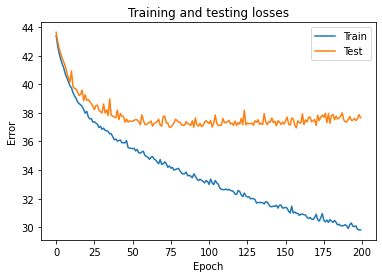

In [46]:
plt.plot(ss_history.history['loss'], label='Train')
plt.plot(ss_history.history['val_loss'], label='Test')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.title('Training and testing losses')
plt.legend()
plt.show()

## SS ON ROTATION, VAL LOSS ~ 31, LOSS ~ 25

In [47]:
test_features = features_model.predict(test_images_ss)
print(test_features.shape)

(1200, 256)


In [48]:
test_predictions = pred_model.predict(test_features)
print(test_predictions.shape)
print(test_predictions)

(1200, 2)
[[ 36.012577 -11.586607]
 [ 39.371197 -17.962624]
 [ 63.672123 -31.404314]
 ...
 [-92.786255  79.34994 ]
 [ 38.95283  -23.964178]
 [ 60.906338 -14.212147]]


In [49]:
header = ['id', 'x', 'y']
with open(ROOTPATH + 'predictions_ss_warp.csv', 'w', newline='') as predictions_ss:
    writer = csv.writer(predictions_ss)
    writer.writerow(header)
    for i in range(len(test_img_names)):
        img_name = test_img_names[i]
        x_val, y_val = test_predictions[i]
        data = [img_name, str(x_val), str(y_val)]
        writer.writerow(data)
    predictions_ss.close()
    